In [1]:
import astropy.time
import astropy.io.fits as pyfits
import astropy.coordinates
import astropy.units as u
from pylab import *

sxi_radius=degrees(arccos(1-0.5/2/pi))*u.deg# assuming 0.5 sr field
xgis_fc_radius=10.5/2*u.deg
xgis_hc_radius=77/2.*u.deg

radius = {'sxi':sxi_radius,'xgis_fc':xgis_fc_radius,'xgis_hc':xgis_hc_radius}

def readsim(fn):
    """docstring for readsim"""
    da = open(fn,'r').readlines()
    start = astropy.time.Time([x.split('|')[0].replace('TDB','').strip()  for x in da[2:]])
    stop = astropy.time.Time([x.split('|')[1].replace('TDB','').strip()  for x in da[2:]])
    tmid = (start.mjd+stop.mjd)/2.
    ra = array([x.split('|')[2].strip()  for x in da[2:]],dtype=float)
    dec = array([x.split('|')[3].strip()  for x in da[2:]],dtype=float)
    return tmid, ra,dec, (stop.mjd-start.mjd)*86400

def readsimgrb(fn):
    """docstring for readsim"""
    da = open(fn,'r').readlines()
    start = astropy.time.Time([x.split()[0].replace('TDB','').strip()  for x in da[2:]])
    stop = astropy.time.Time([x.split()[-2].replace('TDB','').strip()  for x in da[2:]])
    tmid = (start.mjd+stop.mjd)/2.
    ra = array([x.split()[2].replace('TDB','').strip()  for x in da[2:]],dtype=float)
    dec = array([x.split()[3].replace('TDB','').strip()  for x in da[2:]],dtype=float)
    return tmid, ra,dec, (stop.mjd-start.mjd)*86400



tmid,ra,dec,exp = readsim('sim0.txt')
tmidg,rag,decg,expg = readsimgrb('sim0_grb.txt')
tmid = concatenate((tmid,tmidg))
ra = concatenate((ra,rag))
dec = concatenate((dec,decg))
exp = concatenate((exp,expg))
mm = argsort(tmid)
tmid,ra,dec,exp = [x[mm] for x in [tmid,ra,dec,exp]]
bb = astropy.coordinates.SkyCoord(ra*u.deg,dec*u.deg)

def get_coverage(position,instrument='sxi'):
    """Returns time, exposure for given position and instrument ([sxi,xgis_fc,xgis_hc])"""
    pos = astropy.coordinates.name_resolve.get_icrs_coordinates(position)
    mask = where(bb.separation(pos)<=radius[instrument])[0]
    return tmid[mask],exp[mask]
#Now we can try to simulate lightcurve of a given source based on BAT lightcurves. To do that, we need to be able to access those
batc = 'https://swift.gsfc.nasa.gov/results/transients/BAT_catalog.fits'
bat_ra = pyfits.getdata(batc).field('ra_obj')
bat_dec = pyfits.getdata(batc).field('dec_obj')
bat_name = pyfits.getdata(batc).field('name')
bat_fk5 = astropy.coordinates.SkyCoord(bat_ra*u.deg,bat_dec*u.deg,frame='fk5')

def get_bat_lc(position,tol=3*u.arcmin):
    """docstring for get_bat_lc"""
    pos = astropy.coordinates.name_resolve.get_icrs_coordinates(position)
    sep=bat_fk5.separation(pos)
    if min(sep)<=tol:
        n = bat_name[argmin(sep)].replace(' ','').replace('+','p')
        print(n)
        url = "https://swift.gsfc.nasa.gov/results/transients/%s.lc.fits"%n
        tbat = pyfits.getdata(url).field('time')
        rbat = pyfits.getdata(url).field('rate')
        ebat = pyfits.getdata(url).field('error')
        return tbat,rbat,ebat
    else:
        return False

In [2]:
source = 'Her X-1'
instrument='sxi' # must be sxi/xgis_fc/xgis_hc

Text(0.5, 1.0, 'Coverage by SXI for Her X-1')

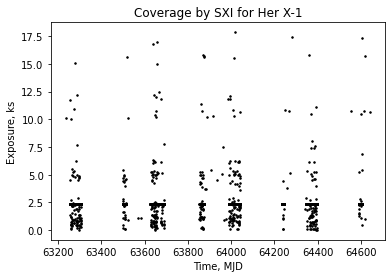

In [3]:
# Now we can coverage for given source position/instrument in the survey
tt, ee =  get_coverage(source,instrument)
plot(tt,ee/1000.,'k.',ms=3)
xlabel('Time, MJD')
ylabel('Exposure, ks')
title('Coverage by %s for %s'%(instrument.upper(),source))


Text(0, 0.5, 'Number of pointings')

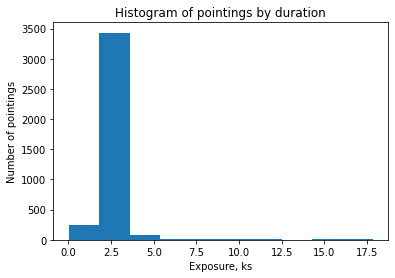

In [4]:
# Get histogram of individual pointing durations
hist(ee/1000.)
title('Histogram of pointings by duration')
xlabel('Exposure, ks')
ylabel('Number of pointings')

Text(0, 0.5, 'Number of segments')

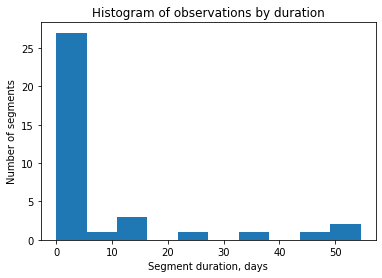

In [5]:
# Now we can get idea on how a given source is observed without a gap
ttt = tt[ee>0]
si = where(diff(ttt)>1)[0]+1
ts = split(ttt,si)
es = split(ee,si)
cont_duration = array([x[-1]-x[0] for x in ts])
hist(cont_duration)
title('Histogram of observations by duration')
xlabel('Segment duration, days')
ylabel('Number of segments')


In [6]:
# Now we can get BAT lightcurve of the source
bat_t, bat_r, bat_e = get_bat_lc(source) # no check for success here!
# adjust it to match Theseus epoch (randomly)
bat_t=bat_t+uniform((tmid[0]-bat_t.min()),(tmid[-1]-bat_t.max()))
# and screen for theseus seasons
mask = where(sum([(bat_t>=min(x))*(bat_t<=max(x)) for x in ts],0))

HerX-1


(63225.17424059386, 64635.17424059386)

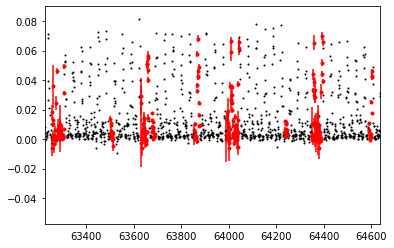

In [7]:
plot(bat_t,bat_r,'k.',ms=2)
errorbar(bat_t[mask],bat_r[mask],bat_e[mask],fmt='r.')
xlim(min(bat_t[mask])-30,max(bat_t[mask])+30)

In [8]:
# Now we can print some summary:
print("%s is observed by %s in %d seasons lasting from %.1f to %.1f days"%(source,instrument,len(ts),min([x[-1]-x[0] for x in ts]),max([x[-1]-x[0] for x in ts])))
print("Average daily exposure during those is %.1f ks/day"%mean([sum(x[1])/(x[0][-1]-x[0][0])/1000 for x in zip(ts,es)]))

Her X-1 is observed by sxi in 36 seasons lasting from 0.0 to 54.5 days
Average daily exposure during those is inf ks/day


<ipython-input-8-3ce075f586e2>:3: RuntimeWarning: divide by zero encountered in double_scalars
  print("Average daily exposure during those is %.1f ks/day"%mean([sum(x[1])/(x[0][-1]-x[0][0])/1000 for x in zip(ts,es)]))
